In [1]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQAWithSourcesChain
from langchain_community.llms import LlamaCpp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import score
import logging
import pickle


logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

## Helpers

In [2]:
retrieval_strategy = "mmr"
model = "llama-2-7b-chat.Q4_K_M"

persist_directory = "./../embeddings"

In [3]:
def process_llm_response(llm_response):
    print("\n\nSources:")
    for i, source in enumerate(llm_response["source_documents"]):
        m = source.metadata
        print(f"{i + 1}. {m['course_title']} ({m['course_number']}): {m['heading']}")

In [17]:
class ResponseFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_response(self, llm_response, ground_truth):
        # self.responses["question"].append(llm_response["query"])
        self.responses["question"].append(llm_response["question"])
        self.responses["contexts"].append(
            [doc.page_content for doc in llm_response["source_documents"]]
        )
        # self.responses["answer"].append(llm_response["result"])
        self.responses["answer"].append(llm_response["answer"])
        self.responses["ground_truth"].append(ground_truth)

    def get_responses(self):
        return self.responses

    def get_dataframe(self):
        pd.DataFrame(self.responses[["question", "answer", "ground_truth"]])

## Vector Retriever

In [5]:
with open(f"{persist_directory}/embeddings.pickle", "rb") as handle:
    embeddings = pickle.load(handle)

In [6]:
vectordb = Chroma(
    "documents",  # or "transcripts"
    embedding_function=embeddings,
    persist_directory=persist_directory,
    collection_metadata={"hnsw:space": "cosine"},
)

In [8]:
retriever = vectordb.as_retriever(
    search_type=f"{retrieval_strategy}",
    search_kwargs={"k": 5, "fetch_k": 20},
)

## Quantized Model

In [9]:
llm_open = LlamaCpp(
    model_path=f"./../models/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
    n_ctx=4096,  # 4096 for Llama, 32*1024 for Mistral
    n_gpu_layers=50,
    temperature=0.15,
    top_p=1,
    top_k=40,
    repeat_penalty=1.1,
    max_tokens=1024,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    stream=True,
)

/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! stream is not default parameter.
                stream was transferred to model_kwargs.
                Please confirm that stream is what you intended.
  warnings.warn(
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /Users/arnewman/.cache/lm-studio/models/TheBloke/Llama-2-7B-Chat-GGUF/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader

In [12]:
# qa_chain = RetrievalQA.from_chain_type(
qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_open,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
)

In [13]:
query = "Which class involves time series analysis?"

llm_response = qa_chain(query)
process_llm_response(llm_response)



> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The class that involves time series analysis is Data Mining II (SIADS 632).
SOURCES:





llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       2.91 ms /    29 runs   (    0.10 ms per token,  9962.21 tokens per second)
llama_print_timings: prompt eval time =   52799.06 ms /  2592 tokens (   20.37 ms per token,    49.09 tokens per second)
llama_print_timings:        eval time =    1313.74 ms /    28 runs   (   46.92 ms per token,    21.31 tokens per second)
llama_print_timings:       total time =   54571.49 ms /  2620 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
3. Data Mining II (SIADS 632): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Communicating Data Science Results (SIADS 523): Course Schedule


## Run the Model

In [14]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    print(row["question"])

Which class involves time series analysis?
Who teaches the SQL and Databases class?
What are the prerequisites for Data Science for Social Good?
When are the office hours for the Math Methods course?
Are there any weekly readings for Milestone II?
What are the outcomes of Qualitative Inquiry?
What textbook is required for SIADS 505?
What textbook is required for Data Manipulation?
Which week of unsupervised learning covers DBSCAN?
How many credits are required to complete the MADS program?
How long do students have to complete the MADS program start to finish?
How many points is the comprehensive oral exam worth in SIADS 593?
What is the penalty for late submission in SIADS 630?
How do I get accommodations for a class?
What is a backpack?
When is the latest I can drop a course?
How do I get an override to take a class?
How do I take a leave of absence from the MADS program?
What are the prerequisites for Search and Recommender Systems?


In [18]:
formatter = ResponseFormatter()

# Or, use the cached one
# with open("./evaluation_set_formatter.pickle", 'rb') as handle:
#     formatter = pickle.load(handle)

In [19]:
for _, row in df.iterrows():
    llm_response = qa_chain(row["question"])
    process_llm_response(llm_response)

    formatter.add_response(llm_response, row["ground_truth"])

    # Save after each response in case this thing crashes
    with open(f"./cache/{retrieval_strategy}_{model}_formatter.pickle", "wb") as handle:
        pickle.dump(formatter, handle)

    with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "wb") as handle:
        pickle.dump(formatter.get_responses(), handle)



> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The class that involves time series analysis is Data Mining II (SIADS 632).







llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       2.72 ms /    27 runs   (    0.10 ms per token,  9922.82 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =    1429.93 ms /    27 runs   (   52.96 ms per token,    18.88 tokens per second)
llama_print_timings:       total time =    1499.44 ms /    28 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
3. Data Mining II (SIADS 632): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Communicating Data Science Results (SIADS 523): Course Schedule


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The instructor for the SQL and Databases class is Graham Hukill.








llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       2.35 ms /    24 runs   (    0.10 ms per token, 10225.82 tokens per second)
llama_print_timings: prompt eval time =   13484.10 ms /   660 tokens (   20.43 ms per token,    48.95 tokens per second)
llama_print_timings:        eval time =    1043.54 ms /    23 runs   (   45.37 ms per token,    22.04 tokens per second)
llama_print_timings:       total time =   14683.06 ms /   683 tokens



> Finished chain.


Sources:
1. SQL and Databases (SIADS 511): Instructor And Course Assistants
2. SQL and Databases (SIADS 511): Course Outcomes
3. SQL and Databases (SIADS 511): Technology Requirements (Unique To This Course)
4. SQL and Databases (SIADS 511): Textbooks
5. SQL and Databases (SIADS 511): Course Schedule


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The prerequisites for Data Science for Social Good include:
- Preceded or accompanied by SIADS 630, 631, and 694; (C- or better)

QUESTION: What are the motivations and incentives for people to contribute to public goods?
Content: Data Science for Social Good (SIADS 688), Course Overview and Prerequisites: This course analyzes the motivations and incentives for people to contribute to public goods. Students will learn how to apply causal inference techniques and social science theories to nudge pro-social behavior. Application domains include energy conservation, safe driving, contributions to open content (Wikipedia), open source, and P2P online microfinance.
Source: 688_2023-08.md

FINAL ANSWER: The motivations and incentives for people to contribute to public goods are a key focus of the Data Science for Social Good course (SIADS 688).


llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =      22.73 ms /   233 runs   (    0.10 ms per token, 10252.57 tokens per second)
llama_print_timings: prompt eval time =   19592.16 ms /   960 tokens (   20.41 ms per token,    49.00 tokens per second)
llama_print_timings:        eval time =   11015.62 ms /   232 runs   (   47.48 ms per token,    21.06 tokens per second)
llama_print_timings:       total time =   31340.49 ms /  1192 tokens



> Finished chain.


Sources:
1. Data Science for Social Good (SIADS 688): Course Syllabus for SIADS 688: Data Science for Social Good Course Overview and Prerequisites
2. Communicating Data Science Results (SIADS 523): Course Syllabus SIADS 523: Communicating Data Science Results (Fall 2023) Course Overview And Prerequisites
3. n/a (n/a): Academics > Master of Applied Data Science (MADS) > Summary of Degree Requirements
4. Data Science Ethics (SIADS 503): Course Learning Outcomes
5. Data Science for Social Good (SIADS 688): Assignments And Grading You Are Expected To Read An Assigned Paper On Perusall Before Watching Each Lecture, And Complete A Problem Set Afterwards.


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The office hours for the Math Methods course are on Wednesdays at 4:00-5:00 pm EST with Hanna Hoover.


QUESTION: What is the main reason for the conflict between Russia and Ukraine?
Content: The conflict between Russia and Ukraine is rooted in Ukraine’s ongoing struggle for sovereignty and territorial integrity. Russia has long considered Ukraine to be within its sphere of influence, and has historically sought to exert significant control over Ukraine’s political and economic affairs. In recent years, Russia has taken a more aggressive stance towards Ukraine, annexing Crimea in 2014 and supporting separatist rebels in eastern Ukraine. The conflict has resulted in significant human suffering, displacement, and economic hardship, and remains unresolved.
Source: 1-pl
Content: The conflict between Russia and Ukraine is rooted in historical, cultural, and political factors. Ukraine has long been a contested territory between East and West, with various powers vying for control throughout


llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =      96.48 ms /   968 runs   (    0.10 ms per token, 10032.65 tokens per second)
llama_print_timings: prompt eval time =   20016.33 ms /   980 tokens (   20.42 ms per token,    48.96 tokens per second)
llama_print_timings:        eval time =   47921.74 ms /   967 runs   (   49.56 ms per token,    20.18 tokens per second)
llama_print_timings:       total time =   70939.56 ms /  1947 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Course Schedule
2. Unsupervised Learning (SIADS 543): Office Hours Schedule:
3. Experiment Design and Analysis (SIADS 631): Course Schedule
4. Causal Inference (SIADS 630): Office Hours:
5. Machine Learning Pipelines (SIADS 643): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 There are no weekly readings for Milestone II.
SOURCES:






llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       2.12 ms /    21 runs   (    0.10 ms per token,  9905.66 tokens per second)
llama_print_timings: prompt eval time =   17190.49 ms /   843 tokens (   20.39 ms per token,    49.04 tokens per second)
llama_print_timings:        eval time =     921.88 ms /    20 runs   (   46.09 ms per token,    21.69 tokens per second)
llama_print_timings:       total time =   18302.55 ms /   863 tokens



> Finished chain.


Sources:
1. Milestone II (SIADS 696): Weekly Readings
2. Milestone II (SIADS 696): Project Component
3. Milestone I (SIADS 593): 6.0 Office Hours
4. Milestone II (SIADS 696): Re-Grade Policy
5. Milestone I (SIADS 593): 7.0 Grading And Course Checklist


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 Qualitative Inquiry for Data Scientists (SIADS 601) has several outcomes for students, including:

1. Collecting, representing, and analyzing qualitative data about a quantitative data set.
2. Developing a narrative about qualitative findings that support later quantitative analysis.
3. Communicating qualitative findings in written form.
Experiment Design and Analysis (SIADS 631) has several outcomes for students, including:

1. Using experiment as a method for causal inference.
2. Knowing when to use blocking versus clustering for random assignment and subsequent data analysis.
3. Knowing basis power calculation.
4. Knowing how to handle spillovers and non-compliance; knowing how to correct for multiple testing.
Causal Inference (SIADS 630) has several outcomes for students, including:

1. Developing awareness of the areas of applications for laboratory and field experiments -- experiments as measurement of individual preferences, as policy interventions, as evaluation method.
Source


llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =      25.56 ms /   260 runs   (    0.10 ms per token, 10171.35 tokens per second)
llama_print_timings: prompt eval time =   26862.43 ms /  1311 tokens (   20.49 ms per token,    48.80 tokens per second)
llama_print_timings:        eval time =   12782.66 ms /   259 runs   (   49.35 ms per token,    20.26 tokens per second)
llama_print_timings:       total time =   40531.86 ms /  1570 tokens



> Finished chain.


Sources:
1. Qualitative Inquiry for Data Scientists (SIADS 601): Learning Outcomes
2. Qualitative Inquiry for Data Scientists (SIADS 601): Course Handouts
3. Qualitative Inquiry for Data Scientists (SIADS 601): Grading And Assignments Overview
4. Experiment Design and Analysis (SIADS 631): Learning Outcomes
5. Causal Inference (SIADS 630): Accommodations


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The textbook required for SIADS 505 is not specified in any of the provided content.
SOURCES:






llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       3.07 ms /    31 runs   (    0.10 ms per token, 10101.01 tokens per second)
llama_print_timings: prompt eval time =    9181.11 ms /   453 tokens (   20.27 ms per token,    49.34 tokens per second)
llama_print_timings:        eval time =    1328.75 ms /    30 runs   (   44.29 ms per token,    22.58 tokens per second)
llama_print_timings:       total time =   10664.79 ms /   483 tokens



> Finished chain.


Sources:
1. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
2. Applied Natural Language Processing (SIADS 655): Textbook Information
3. Presenting Uncertainty (SIADS 524): Required Textbook
4. Math Methods I (SIADS 502): Academic Integrity
5. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The textbook required for Data Manipulation (SIADS 505) is "Storytelling With Data: The Effective Visual Communication of Information" by Cole Nussbaumer Knaflic.







































































































































































































































































































































































































































































































































































































































































































































































































































































llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =     101.30 ms /  1024 runs   (    0.10 ms per token, 10108.49 tokens per second)
llama_print_timings: prompt eval time =   15102.45 ms /   741 tokens (   20.38 ms per token,    49.06 tokens per second)
llama_print_timings:        eval time =   49493.08 ms /  1023 runs   (   48.38 ms per token,    20.67 tokens per second)
llama_print_timings:       total time =   67678.65 ms /  1764 tokens



> Finished chain.


Sources:
1. Data Manipulation (SIADS 505): Course Syllabus Course Overview And Prerequisites
2. Communicating Data Science Results (SIADS 523): Required Textbook
3. Data Manipulation (SIADS 505): Library Access
4. Math Methods II (SIADS 602): Textbooks For Optional Readings
5. Health Analytics (SIADS 681): Weekly Readings or Textbook Information


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 DBSCAN is covered in Week 2 of Unsupervised Learning (SIADS 543).
SOURCES: 543_2023-09.md, 543_2023-09.md, 511_2023-10.md, 680_2023-10.md


llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       8.67 ms /    87 runs   (    0.10 ms per token, 10038.08 tokens per second)
llama_print_timings: prompt eval time =   11649.44 ms /   570 tokens (   20.44 ms per token,    48.93 tokens per second)
llama_print_timings:        eval time =    3869.56 ms /    86 runs   (   44.99 ms per token,    22.22 tokens per second)
llama_print_timings:       total time =   15824.14 ms /   656 tokens



> Finished chain.


Sources:
1. Unsupervised Learning (SIADS 543): Learning Outcomes: Week 2
2. SQL and Databases (SIADS 511): Course Schedule
3. Unsupervised Learning (SIADS 543): Schedule
4. Learning Analytics and Educational Data Science (SIADS 680): Office Hours Via Zoom (Ann Arbor, Michigan Time - Eastern Time Zone)
5. Unsupervised Learning (SIADS 543): Quizzes


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The MADS program requires 34 credits to be completed.




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =     101.92 ms /  1024 runs   (    0.10 ms per token, 10047.00 tokens per second)
llama_print_timings: prompt eval time =   22401.77 ms /  1090 tokens (   20.55 ms per token,    48.66 tokens per second)
llama_print_timings:        eval time =   51318.92 ms /  1023 runs   (   50.17 ms per token,    19.93 tokens per second)
llama_print_timings:       total time =   76857.47 ms /  2113 tokens



> Finished chain.


Sources:
1. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
2. n/a (n/a): Course Planning > Q: What is the recommended number of credits students should take?
3. n/a (n/a): Course Planning > Q: When will courses be offered next?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. Unsupervised Learning (SIADS 543): Grading And Course Checklist


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The length of time it takes to complete the MADS program is five years from the date of first enrollment in the program.

















































































































































































































































































































































































































































































































































































































































































































































































































































































































llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =     101.75 ms /  1024 runs   (    0.10 ms per token, 10063.39 tokens per second)
llama_print_timings: prompt eval time =   20862.49 ms /  1024 tokens (   20.37 ms per token,    49.08 tokens per second)
llama_print_timings:        eval time =   51049.61 ms /  1024 runs   (   49.85 ms per token,    20.06 tokens per second)
llama_print_timings:       total time =   75106.31 ms /  2048 tokens



> Finished chain.


Sources:
1. n/a (n/a): General Academic Advising > Q: How long do I have to complete the program?
2. n/a (n/a): Course Planning > Q: How are the MADS courses/semesters set up?
3. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Standards and Processes > Leaving Course Channels


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The comprehensive oral exam is worth 40 points in SIADS 593.
SOURCES:






llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       2.95 ms /    30 runs   (    0.10 ms per token, 10169.49 tokens per second)
llama_print_timings: prompt eval time =   12756.00 ms /   632 tokens (   20.18 ms per token,    49.55 tokens per second)
llama_print_timings:        eval time =    1354.30 ms /    30 runs   (   45.14 ms per token,    22.15 tokens per second)
llama_print_timings:       total time =   14283.33 ms /   662 tokens



> Finished chain.


Sources:
1. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade
2. Milestone II (SIADS 696): Comprehensive Exam Component
3. Milestone I (SIADS 593): 4.0 Weekly Readings
4. Unsupervised Learning (SIADS 543): Quizzes
5. Information Visualization I (SIADS 522): Letter Grades, Course Grades, And Late Submission Policy


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The penalty for late submission in SIADS 630 is 15% daily-recurring reduction in grade for the first three days after the submission deadline, and a zero (0) if your assignment is turned in four or more days late.




















































































































































































































































































































































































































































































































































































































































































































































































































llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =     102.02 ms /  1024 runs   (    0.10 ms per token, 10037.44 tokens per second)
llama_print_timings: prompt eval time =   21827.52 ms /  1068 tokens (   20.44 ms per token,    48.93 tokens per second)
llama_print_timings:        eval time =   51245.12 ms /  1023 runs   (   50.09 ms per token,    19.96 tokens per second)
llama_print_timings:       total time =   76203.70 ms /  2091 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Quizzes, Assignments, And Late Penalties
2. Capstone (SIADS 699): Late Submission Policy
3. Causal Inference (SIADS 630): Late Policy
4. Milestone II (SIADS 696): Late Submission Policy
5. Presenting Uncertainty (SIADS 524): Late Submissions


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 To get accommodations for a class, you should contact the Services for Students with Disabilities (SSD) at the University of Michigan. You can also complete the Student Application Form in Accommodate to begin the process of working with SSD. It is important to register with SSD and obtain approved accommodations in a timely manner.


llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       7.08 ms /    72 runs   (    0.10 ms per token, 10163.75 tokens per second)
llama_print_timings: prompt eval time =   20403.92 ms /   998 tokens (   20.44 ms per token,    48.91 tokens per second)
llama_print_timings:        eval time =    3346.98 ms /    71 runs   (   47.14 ms per token,    21.21 tokens per second)
llama_print_timings:       total time =   24082.36 ms /  1069 tokens



> Finished chain.


Sources:
1. n/a (n/a): Additional University Resources > Q: I need accommodations to best support my learning. Who can I talk to?
2. Data Science for Social Good (SIADS 688): Accommodations
3. n/a (n/a): Accommodations for Students with Disabilities Policy
4. n/a (n/a): Accommodations for Students with Disabilities Policy
5. Math Methods II (SIADS 602): Accommodations


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 A backpack is a type of bag used for carrying things like books, clothes, and other personal items.






































































































































































































































































































































































































































































































































































































































































































































































































































































































































llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =     101.55 ms /  1024 runs   (    0.10 ms per token, 10083.60 tokens per second)
llama_print_timings: prompt eval time =   13633.09 ms /   668 tokens (   20.41 ms per token,    49.00 tokens per second)
llama_print_timings:        eval time =   48954.25 ms /  1023 runs   (   47.85 ms per token,    20.90 tokens per second)
llama_print_timings:       total time =   65693.41 ms /  1691 tokens



> Finished chain.


Sources:
1. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
2. Milestone II (SIADS 696): Technology Tips
3. Visual Exploration of Data (SIADS 521): Use Of External Resources And Services (E.G Chatgpt)
4. Visual Exploration of Data (SIADS 521): Accessibility
5. Learning Analytics and Educational Data Science (SIADS 680): Library Access


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The latest time to drop a course is on the last day of classes for each session.
SOURCES: advising_guide.md, 642_2023-11.md, handbook.md


llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       4.83 ms /    49 runs   (    0.10 ms per token, 10153.34 tokens per second)
llama_print_timings: prompt eval time =   13269.43 ms /   653 tokens (   20.32 ms per token,    49.21 tokens per second)
llama_print_timings:        eval time =    2172.55 ms /    48 runs   (   45.26 ms per token,    22.09 tokens per second)
llama_print_timings:       total time =   15662.30 ms /   701 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What’s the latest that I can late drop a course?
2. n/a (n/a): Class Registration > Q: What do I need to do to drop a course during the add/drop period?
3. Deep Learning I (SIADS 642): Course Schedule
4. n/a (n/a): Course Planning > Q: When will courses be offered next?
5. n/a (n/a): Academics > Time Limit


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The president did not mention Michael Jackson.







llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =       1.39 ms /    14 runs   (    0.10 ms per token, 10064.70 tokens per second)
llama_print_timings: prompt eval time =   27540.20 ms /  1344 tokens (   20.49 ms per token,    48.80 tokens per second)
llama_print_timings:        eval time =     690.89 ms /    14 runs   (   49.35 ms per token,    20.26 tokens per second)
llama_print_timings:       total time =   28469.72 ms /  1358 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What is a Backpack?
2. n/a (n/a): Class Registration > Q: What’s the latest that I can late drop a course?
3. Social Media Analytics (SIADS 682): Content Warnings
4. Unsupervised Learning (SIADS 543): Grading And Course Checklist
5. n/a (n/a): Academics > Petition for Modification or Waiver of Policy


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 To take a leave of absence from the MADS program, you must notify the MADS Academic Advising Team of your intentions. If you have already registered for classes, you will need to submit a term withdrawal form available from the UMSI Registrar Team. If you have any questions or concerns about taking a leave of absence, please contact the MADS Academic Advising Team at [umsi.advising.mads@umich.edu](mailto:umsi.advising.mads@umich.edu).



















































































































































































































































































































































































































































































































































































llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =     102.51 ms /  1024 runs   (    0.10 ms per token,  9989.46 tokens per second)
llama_print_timings: prompt eval time =   27047.14 ms /  1320 tokens (   20.49 ms per token,    48.80 tokens per second)
llama_print_timings:        eval time =   52584.35 ms /  1024 runs   (   51.35 ms per token,    19.47 tokens per second)
llama_print_timings:       total time =   82955.09 ms /  2344 tokens



> Finished chain.


Sources:
1. n/a (n/a): Academics > Leave of Absence
2. n/a (n/a): Academics > Grades and Grading Policy > Grade of Incomplete (I)
3. n/a (n/a): Additional University Resources > Q: What mental health resources are available to MADS students?
4. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Practices > Acknowledge, even when you want to work on it later
5. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?


> Entering new RetrievalQAWithSourcesChain chain...


Llama.generate: prefix-match hit


 The prerequisites for Search and Recommender Systems (SIADS 685) include:
- Advisory Prerequisites: SIADS 642: Deep learning, SIADS 652: Network analysis, SIADS 655: Applied NLP, SIADS 611: Database Architecture and Technology
- Enforced Prerequisites: SIADS 694 (first half of Milestone II)
The instructor for SIADS 685 is Michelle LeBlanc, and the course assistants are Sharon Sung and Toby Kemp.
For Data Science for Social Good (SIADS 688), the prerequisites include:
- Advisory Prerequisites: None
- Enforced Prerequisites: None
The readings for Week 2 of SIADS 685 include Q. Mei and D. Radev, " Information Retrieval  ", Chapter in The Oxford Handbook of Computational Linguistics 2nd edition, and C.Zhai and S.Massung, " Text Data Management and Analysis - A Practical Introduction to Information Retrieval and Text Mining  ", Chapter 6, 7, 10.
For Data Science for Social Good (SIADS 688), the readings for Week 4 include Yan Chen, Rosta Farzan, Robert Kraut, Iman YeckehZaare and Ark Fangz


llama_print_timings:        load time =    6920.68 ms
llama_print_timings:      sample time =      41.86 ms /   427 runs   (    0.10 ms per token, 10199.94 tokens per second)
llama_print_timings: prompt eval time =   15892.24 ms /   784 tokens (   20.27 ms per token,    49.33 tokens per second)
llama_print_timings:        eval time =   20067.30 ms /   426 runs   (   47.11 ms per token,    21.23 tokens per second)
llama_print_timings:       total time =   37190.58 ms /  1210 tokens



> Finished chain.


Sources:
1. Search and Recommender Systems (SIADS 685): Course Overview And Prerequisites
2. Search and Recommender Systems (SIADS 685): Instructor And Course Assistants
3. Search and Recommender Systems (SIADS 685): Week 2: Retrieval Models, Web Search (Part I)
4. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
5. Data Science for Social Good (SIADS 688): Week 4 - Personalizing The Ask: Open Content, Recommender, And Reputation Systems


## Evaluation with BERTScore

In [20]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [21]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
 The class that involves time series analysis is Data Mining II (SIADS 632).







Who teaches the SQL and Databases class?
>>> The primary instructor for SQL and Databases is Graham Hukill. Additional course assistants include, Derek Bruckner, Emily Schemanske, Jungseo Lee, and Toby Kemp.
----------------------------------------------------------------------------------------------------
 The instructor for the SQL and Databases class is Graham Hukill.








What are the prerequisites for Data Science for Social Good?
>>> SIADS 630, 631, and 694
----------------------------------------------------------------------------------------------------
 The prerequisites for Data Science for Social Good include:
- Preceded or accompanied by SIADS 630, 631, and 694; (

In [24]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    1,  # 'Which class involves time series analysis?',
    1,  # 'Who teaches the SQL and Databases class?',
    1,  # 'What are the prerequisites for Data Science for Social Good?',
    -1,  # 'When are the office hours for the Math Methods course?',
    1,  # 'Are there any weekly readings for Milestone II?',
    -1,  # 'What are the outcomes of Qualitative Inquiry?',
    -1,  # 'What textbook is required for SIADS 505?',
    -1,  # 'What textbook is required for Data Manipulation?',
    1,  # 'Which week of unsupervised learning covers DBSCAN?',
    1,  # 'How many credits are required to complete the MADS program?',
    1,  # 'How long do students have to complete the MADS program start to finish?',
    -1,  # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1,  # 'What is the penalty for late submission in SIADS 630?',
    1,  # 'How do I get accommodations for a class?',
    -1,  # 'What is a backpack?',
    1,  # 'When is the latest I can drop a course?',
    -1,  # 'How do I get an override to take a class?',
    1,  # 'How do I take a leave of absence from the MADS program?',
    1,  # 'What are the prerequisites for Search and Recommender Systems?'
]

In [22]:
scores = [
    [
        t.item()
        for t in score(
            [rag_responses["answer"][i]],
            [rag_responses["ground_truth"][i]],
            rescale_with_baseline=True,
            lang="en",
        )
    ]
    for i in range(len(rag_responses["question"]))
]

with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "wb") as handle:
    pickle.dump(scores, handle)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [25]:
with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "rb") as handle:
    scores = pickle.load(handle)

bert_df = pd.concat(
    [
        responses_df,
        pd.DataFrame(scores, columns=["precision", "recall", "f1"]),
    ],
    axis="columns",
)

bert_df["abs_diff"] = (bert_df["eye_check"] - bert_df["f1"]).abs()

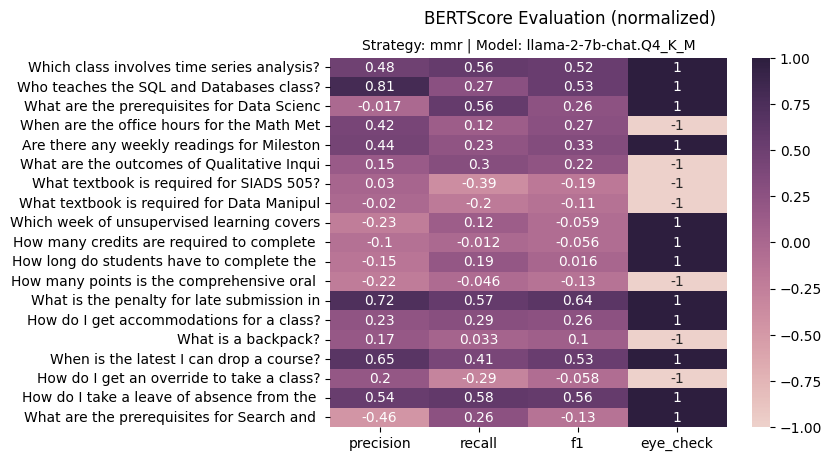

In [26]:
sns.heatmap(
    bert_df[["precision", "recall", "f1", "eye_check"]],
    yticklabels=bert_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("BERTScore Evaluation (normalized)")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()